<a href="https://www.kaggle.com/code/iqmansingh/machine-failures-xgboost-parameter-tuning?scriptVersionId=133993879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
print("Setup Complete")

/kaggle/input/machine-failure-predictions/machine failure.csv
/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
Setup Complete


# Importing Datasets

In [3]:
train_path = "../input/playground-series-s3e17/train.csv"
orig_path = "../input/machine-failure-predictions/machine failure.csv"
test_path = "../input/playground-series-s3e17/test.csv"

train_data = pd.read_csv(train_path,index_col="id")
orig_data = pd.read_csv(orig_path,index_col="UDI")
test_data = pd.read_csv(test_path,index_col="id")

train_data = train_data.append(orig_data)
train_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [4]:
print(train_data.info(),test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146429 entries, 0 to 10000
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               146429 non-null  object 
 1   Type                     146429 non-null  object 
 2   Air temperature [K]      146429 non-null  float64
 3   Process temperature [K]  146429 non-null  float64
 4   Rotational speed [rpm]   146429 non-null  int64  
 5   Torque [Nm]              146429 non-null  float64
 6   Tool wear [min]          146429 non-null  int64  
 7   Machine failure          146429 non-null  int64  
 8   TWF                      146429 non-null  int64  
 9   HDF                      146429 non-null  int64  
 10  PWF                      146429 non-null  int64  
 11  OSF                      146429 non-null  int64  
 12  RNF                      146429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 15.6+ MB
<c

In [5]:
train_data.drop(["Product ID"],inplace=True,axis=1)
test_data.drop(["Product ID"],inplace=True,axis=1)

In [6]:
test_data.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

# Data Cleaning

In [7]:
train_data.columns = ['Type', 'Air_Temp_K', 'Process_Temp_K', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'Machine_Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
test_data.columns = ['Type', 'Air_Temp_K', 'Process_Temp_K', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

catDTypeCols = ['Type']

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train_data["Type"] = encoder.fit_transform(train_data["Type"])
test_data["Type"] = encoder.transform(test_data["Type"])
train_data.head()

,Type,Air_Temp_K,Process_Temp_K,Rot_Speed,Torque,Tool_Wear,Machine_Failure,TWF,HDF,PWF,OSF,RNF
0,1,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,2,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,1,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,1,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,2,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [9]:
train_data["Temp_Diff"] = train_data["Process_Temp_K"]-train_data["Air_Temp_K"]
test_data["Temp_Diff"] = test_data["Process_Temp_K"]-test_data["Air_Temp_K"]

train_data["Air_Temp_C"] = train_data["Air_Temp_K"]-273
test_data["Air_Temp_C"] = test_data["Air_Temp_K"]-273

train_data["Process_Temp_C"] = train_data["Process_Temp_K"]-273
test_data["Process_Temp_C"] = test_data["Process_Temp_K"]-273

train_data["Power"] = train_data["Torque"]*train_data["Rot_Speed"]
test_data["Power"] = test_data["Torque"]-test_data["Rot_Speed"]

# Normalizing Data

In [10]:
train_data.columns

Index(['Type', 'Air_Temp_K', 'Process_Temp_K', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'Machine_Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'Temp_Diff', 'Air_Temp_C', 'Process_Temp_C', 'Power'],
      dtype='object')

In [11]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

numericalCols = ['Air_Temp_K','Air_Temp_C','Process_Temp_C','Process_Temp_K','Rot_Speed','Torque','Tool_Wear','Temp_Diff',"Power"]

train_nor = train_data.copy()
test_nor = test_data.copy()

for i in numericalCols:
    x = np.array(train_data[i]).reshape(-1,1)
    scaler = MaxAbsScaler()
    scaler.fit(x)
    train_nor[i] = scaler.fit_transform(x).reshape(1,-1)[0]
    
for i in numericalCols:
    x = np.array(test_data[i]).reshape(-1,1)
    scaler = MaxAbsScaler()
    scaler.fit(x)
    test_nor[i] = scaler.fit_transform(x).reshape(1,-1)[0]

# Exploratory Data Analysis

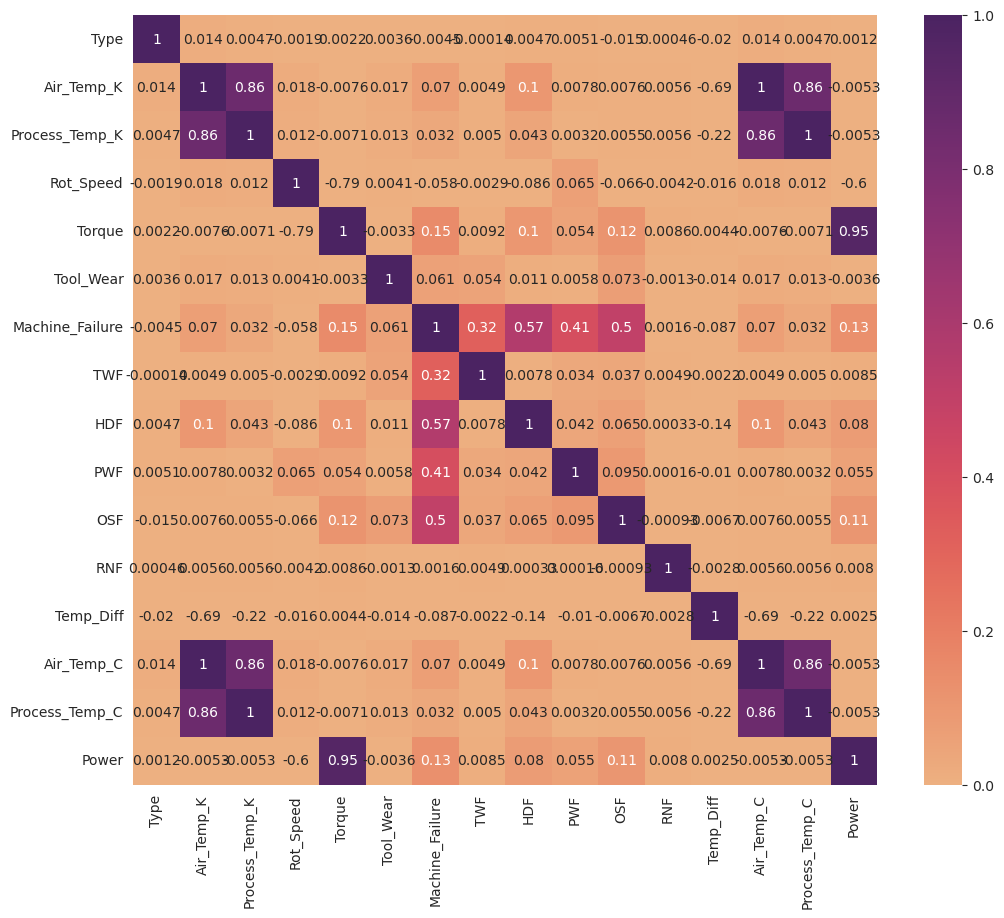

In [12]:
features = [i for i in train_data.columns]
corr = train_nor[features].corr(numeric_only=False)
plt.figure(figsize = (12,10))
sns.heatmap(corr, cmap = 'flare', annot = True,vmin=0);
plt.show()

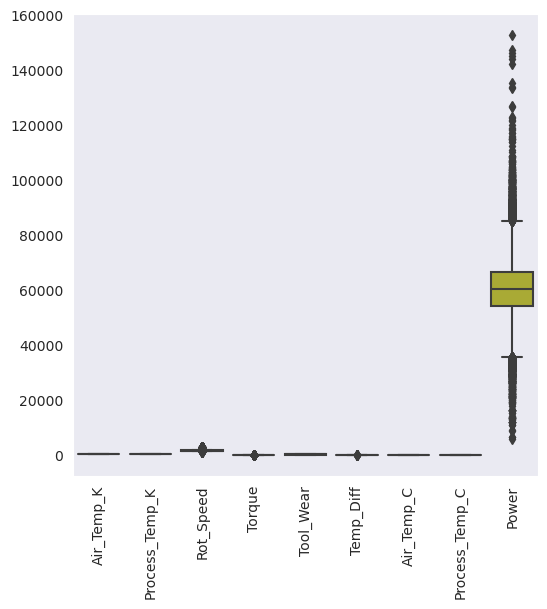

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Air_Temp_K'),
  Text(1, 0, 'Process_Temp_K'),
  Text(2, 0, 'Rot_Speed'),
  Text(3, 0, 'Torque'),
  Text(4, 0, 'Tool_Wear'),
  Text(5, 0, 'Temp_Diff'),
  Text(6, 0, 'Air_Temp_C'),
  Text(7, 0, 'Process_Temp_C'),
  Text(8, 0, 'Power')])

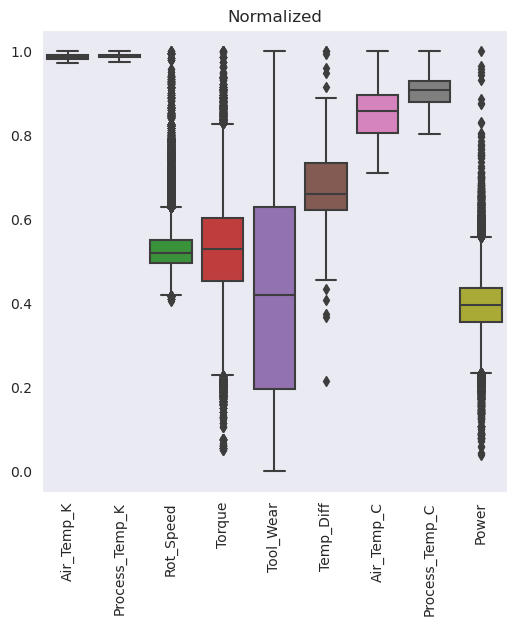

In [13]:
plotCols = [i for i in train_data.columns if len(train_nor[i].unique())>3]

plt.figure(figsize=(6,6))
sns.boxplot(train_data[plotCols]);
plt.xticks(rotation=90)
plt.show();

plt.figure(figsize=(6,6))
plt.title("Normalized")
sns.boxplot(train_nor[plotCols]);
plt.xticks(rotation=90)

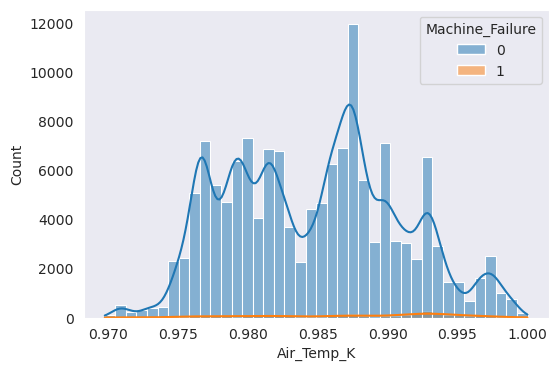

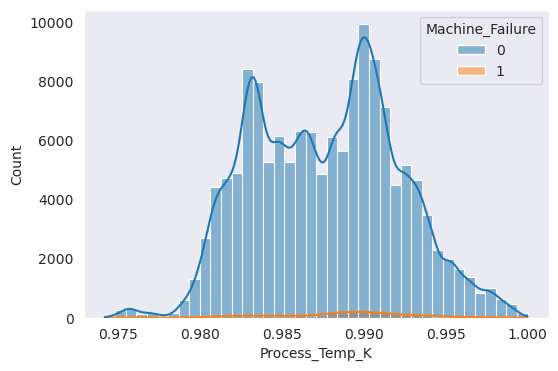

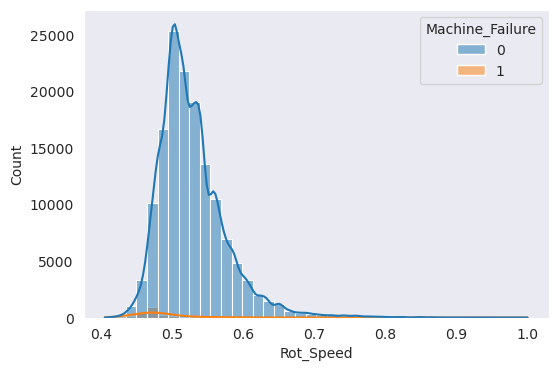

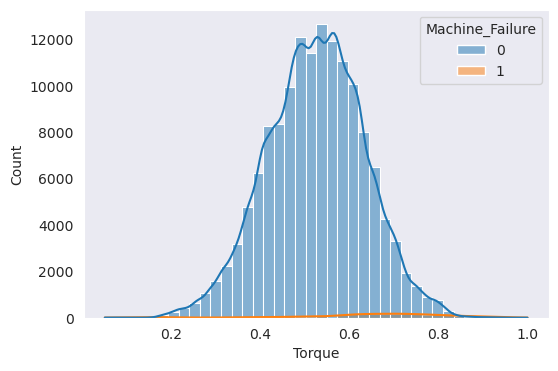

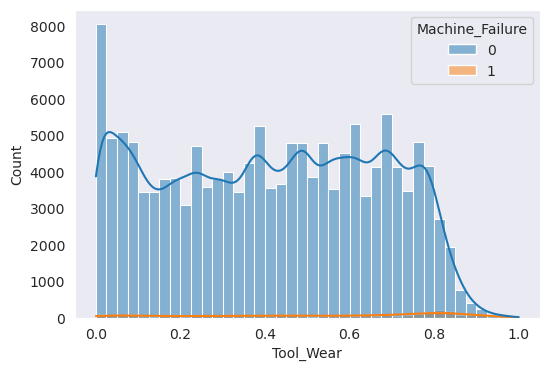

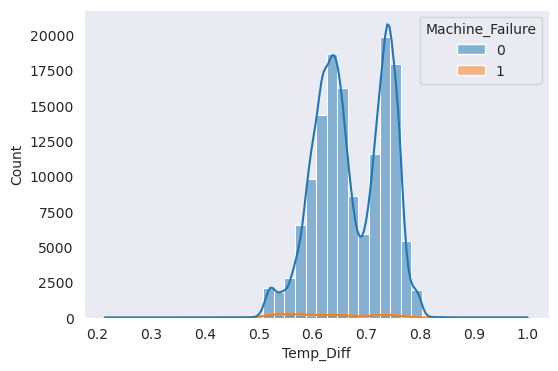

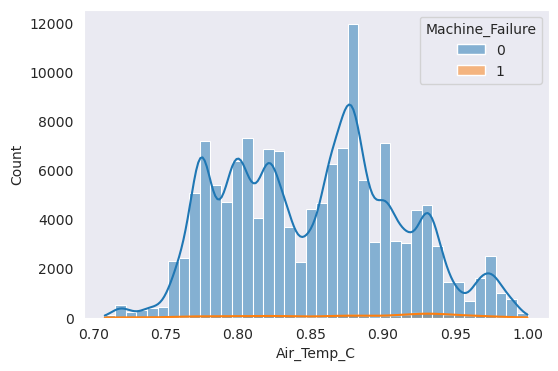

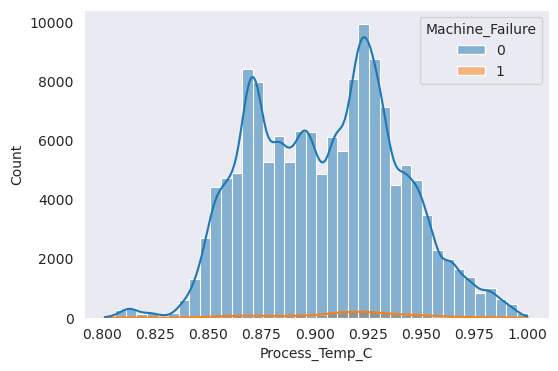

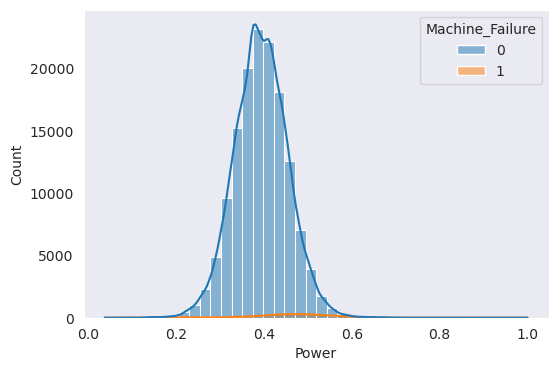

In [14]:
for i in plotCols:
    plt.figure(figsize=(6,4))
    sns.histplot(train_nor,x =i,hue="Machine_Failure",bins=40,kde=True);
    plt.show()

# Training Model 

In [15]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [16]:
cols = [i for i in train_nor.columns if i!="Machine_Failure"]
seed = np.random.seed(0)

X = train_nor[cols]
y = train_nor["Machine_Failure"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=seed)

In [17]:
# xgbmodel = XGBClassifier(max_depth=7,n_estimators=500,learning_rate=0.05,
#                          random_state=seed,eval_metric= "auc")
# xgbmodel.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=100,verbose=5)


# pred = xgbmodel.predict(X_test)
# pred_proba = xgbmodel.predict_proba(X_test)[:,1]
# print("1 ROC Area Under Curve of XGB:",roc_auc_score(y_test, pred))
# print("2 ROC Area Under Curve of XGB:",roc_auc_score(y_test, pred_proba))

In [ ]:
params  = {
    'n_estimators':[1500, 2000],
    'learning_rate': [0.02, 0.01],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}
xgbmodel = XGBClassifier(random_state=seed,eval_metric= "auc",tree_method='gpu_hist', predictor='gpu_predictor')
grid_search = GridSearchCV(xgbmodel, params, cv=5, verbose=3, scoring="roc_auc")
grid_search.fit(X,y)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END gamma=0.1, learning_rate=0.025, max_depth=3, min_child_weight=1, n_estimators=1500;, score=0.963 total time=   1.7s
[CV 2/3] END gamma=0.1, learning_rate=0.025, max_depth=3, min_child_weight=1, n_estimators=1500;, score=0.963 total time=   1.8s
[CV 3/3] END gamma=0.1, learning_rate=0.025, max_depth=3, min_child_weight=1, n_estimators=1500;, score=0.977 total time=   1.7s
[CV 1/3] END gamma=0.1, learning_rate=0.025, max_depth=3, min_child_weight=1, n_estimators=2000;, score=0.961 total time=   2.2s
[CV 2/3] END gamma=0.1, learning_rate=0.025, max_depth=3, min_child_weight=1, n_estimators=2000;, score=0.963 total time=   2.3s
[CV 3/3] END gamma=0.1, learning_rate=0.025, max_depth=3, min_child_weight=1, n_estimators=2000;, score=0.977 total time=   2.2s
[CV 1/3] END gamma=0.1, learning_rate=0.025, max_depth=3, min_child_weight=3, n_estimators=1500;, score=0.963 total time=   1.7s
[CV 2/3] END gamma=0.1, learning_ra

# Predictions from GridSearchCV

In [90]:
predictions = grid_search.predict_proba(test_nor)[:,1]

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Plotting Feature Importance

In [89]:
# df = pd.DataFrame()
# df["imp"] = grid_search.best_estimator_.feature_importance_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

# Creating 'submission.csv' 

In [ ]:
submission = test_nor.copy()

colsToDrop = [i for i in submission.columns]
submission.drop(colsToDrop,axis=1,inplace=True)
submission["Machine failure"] = predictions

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv",index=True,header=True)